In [25]:
# import test_tensor_2d as tt ttbd
import quimb.tensor as qtn
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import spinlessQubit as sq
import hubbardJWT as hjw
import electronHubJW as ejw
import stabilizers as stab
import qubitNetworks as beeky
from itertools import product


In [13]:
reload(sq)
sql = sq.SpinlessQubitLattice()
sql.t_make_stabilizers()

Stabilizer:
1-----2
|     |
4-----5
None None 6 None



In [19]:
reload(sq)
reload(hjw)

##Testing params
T_PARAM=1
V_PARAM=0
MU_PARAM=0
LX, LY = 2, 3


### Analytical Hubbard Hamiltonian
hub = hjw.HubbardSpinless(Lx=LX, Ly=LY)
hub.build_spinless_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
Hexact = hub._Ham.copy()
gex, gsx = qu.eigh(Hexact)
print('Exact: {}'.format(gex[0]))

nx = hub.state_occs(state=gsx[:,0])
print(nx,end='\n\n')


### Qubit lattice Hamiltonian
sql = sq.SpinlessQubitLattice(Lx=LX,Ly=LY)
sql.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
sql.make_stabilizer()

rotHam = sql.projected_ham_3() 
Uplus = sql._Uplus
rens, reigst = qu.eigh(rotHam)
print(rens[0])

print(sql.state_local_occs(k=None, qstate=Uplus@reigst[:,0]))

Exact:  -3.8284271247461907
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]]

Stabilizer:
1-----2
|     |
4-----5
None None 6 None

-3.828427124746188
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]]


In [36]:
# Hsim = sql.ham_sim()
st =(   qu.computational_state('0000000')+
        qu.computational_state('0000001')
    )
# Hhop = sql.H_hop(0,1,None,'horizontal')
# ups.H @ Hhop @ ups
st.H@Hsim@st

[[0.+0.j]]

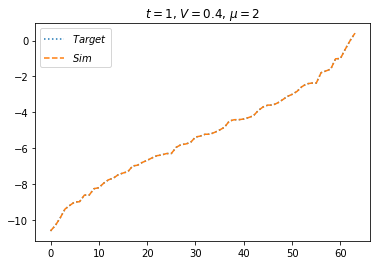

In [163]:
plt.plot(gex, ':', label=r'$Target$') #exact Hubbard energies
plt.plot(rens, '--',label=r'$Sim$')

plt.title(r'$t={}$, $V={}$, $\mu={}$'.format(T_PARAM,V_PARAM,MU_PARAM))
plt.legend()


In [6]:
for k in range(64):
    A = hub.state_occs(qu.basis_vec(i=k, dim=64))
    B = sql.state_local_occs(qstate=Uplus[:,k])
    assert np.allclose(A,B) #may not hold when degeneracies
sql.one_qubit_dm(Uplus@reigst[:,0], i=5)

[[0.107496+0.j 0.      +0.j]
 [0.      +0.j 0.892504+0.j]]

In [29]:
# reload(ejw)

# ehub = ejw.ElectronHubbard()
# ehub.build_hubbard_ham()
ehub._Ham.shape

(4096, 4096)

In [16]:
# reload(stab)
reload(sq)
# qlat = sq.SpinlessQubitLattice(Lx=3, Ly=3)
# Uplus = stab.two_qubit_codespace(qlat)
# Uplus.shape
# qlat = sq.SpinlessQubitLattice(Lx=4,Ly=3)
# Up3 = stab.three_qubit_stabilizer(qlat)
reload(hjw)
hubhalf = hjw.HubbardSpinHalf(2,3,1.0,1.5)
hubhalf.build_spinhalf_ham()
h2ex = hubhalf.HamExact()
h2ex.shape


(4096, 4096)

In [6]:
# Vs, Fs = sq.gen_lattice_sites(3,3)
# edgesR =sq.get_R_edges(Vs, Fs)
[f'Q{i},Q{j},Q{k}' for (i,j,k) in edgesR]

['Q3,Q4,Q9', 'Q4,Q5,Q10']

In [23]:
reload(beeky)
reload(sq)

T_PARAM=1.0
V_PARAM=1.5
MU_PARAM=1.5

qlat = sq.SpinlessQubitLattice(Lx=2,Ly=3)
qenet = beeky.QubitEncodeNet(qlat)
MyHam = beeky.SimulatorHam(qlat, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)

print('Naive:',qenet.compute_energy_deprec(T_PARAM, V_PARAM, MU_PARAM))

print('<H>:  ',qenet.compute_ham_expec(MyHam))

qlat.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
H_d = qlat.ham_sim()
psi_d = qenet.to_dense()

print('Dense:',(psi_d.H @ H_d @ psi_d)[0][0])


Naive: (-0.2742976036603611-4.6485168145316e-18j)
<H>:   (-0.2742976036603629-4.6485168145316e-18j)
Dense: (-0.2742976036603626+0j)


0.1587044679716266


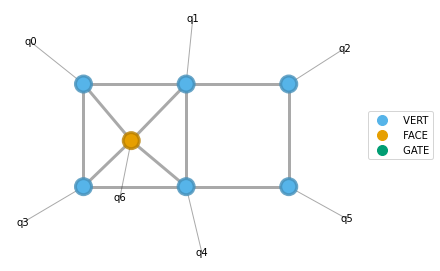

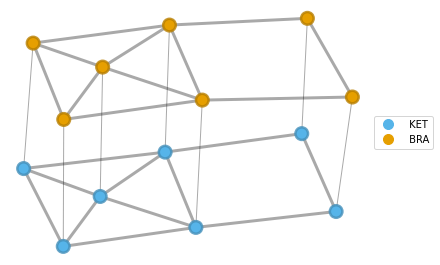

In [24]:
qenet.graph_psi()
norm=qenet.make_norm_tensor()
print(norm^all)
norm.graph(color=['KET','BRA'],show_tags=0)
